# CNN Algorithm for dazzled camera identification

In [43]:
import numpy as np 
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
from scipy import stats
import keras.backend as K
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, RandomFlip, RandomRotation, BatchNormalization, SpatialDropout2D
#from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.preprocessing import RobustScaler, MaxAbsScaler
from tensorflow.keras.metrics import BinaryCrossentropy as metricBinaryCrossentropy
from tensorflow.keras.metrics import FalseNegatives, BinaryIoU ,AUC#, F1Score
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.optimizers import Nadam ,schedules
from tensorflow.image import resize_with_crop_or_pad
from tensorflow import cast, expand_dims, float32, random
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score

In [44]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Import data and MC truth


In [45]:
data_path = './dazzled_cameras_dataset'
#neutrino-01 path: '/storage/gpfs_data/neutrino/SAND-LAr/SAND-LAr-OPTICALSIM-PROD/GRAIN/dazzledcam/data'

# Load Data 
# with open(data_path+'/simulation_0.npy', 'rb') as a:    #'+str(sim_num)+'
#     data_in_0 = np.load(a)  
with open(data_path+'/simulation_11.npy', 'rb') as b:    #'+str(sim_num)+'
    data_in_1 = np.load(b)
with open(data_path+'/simulation_22.npy', 'rb') as c:    #'+str(sim_num)+'
    data_in_2 = np.load(c)
with open(data_path+'/simulation_33.npy', 'rb') as c:    #'+str(sim_num)+'
    data_in_3 = np.load(c)
    
# Load MC Truth
# with open(data_path+'/inner_ph_0.npy', 'rb') as e:      #'+str(sim_num)+'
#     ph_in_0 = np.load(e)
with open(data_path+'/inner_ph_11.npy', 'rb') as f:      #'+str(sim_num)+'
    ph_in_1 = np.load(f)
with open(data_path+'/inner_ph_22.npy', 'rb') as g:      #'+str(sim_num)+'
    ph_in_2 = np.load(g)
with open(data_path+'/inner_ph_33.npy', 'rb') as g:      #'+str(sim_num)+'
    ph_in_3 = np.load(g)    

In [46]:
### Reshaping data_0
# d0 = data_in_0.reshape(-1, 31, 31 )
# new_data_0 = np.array(resize_with_crop_or_pad(d0.T.reshape(31,31,-1), 32, 32)).T
# new_data_0.shape

## Dataset analysis

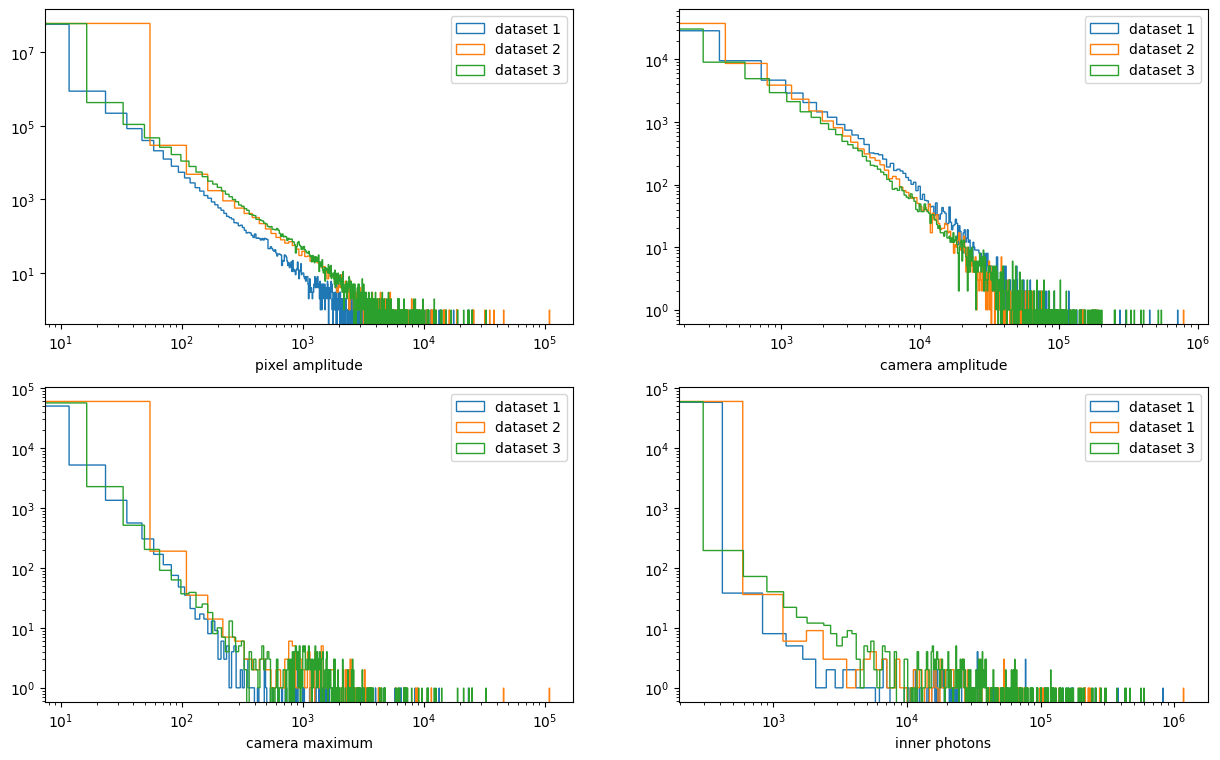

In [47]:
###### fixed parameters ###########
n_cam_in_grain_0 = 54
n_cam_in_grain_1 = 58
n_cam_in_grain_2 = 60
n_cam_in_grain_3 = 60
cam_side_length = 32
###################################

fig, ax = plt.subplots(2,2)

ax[0,0].hist(data_in_1, 2000, histtype='step', label='dataset 1');
ax[0,0].hist(data_in_2, 2000, histtype='step', label='dataset 2');
ax[0,0].hist(data_in_3, 2000, histtype='step', label='dataset 3');
ax[0,0].set_yscale('log')
ax[0,0].set_xscale('log')
ax[0,0].set_xlabel('pixel amplitude')
ax[0,0].legend()

ax[0,1].hist(np.sum(data_in_1.reshape(-1, cam_side_length**2), axis=1), 2000, histtype='step', label='dataset 1');
ax[0,1].hist(np.sum(data_in_2.reshape(-1, cam_side_length**2), axis=1), 2000, histtype='step', label='dataset 2');
ax[0,1].hist(np.sum(data_in_3.reshape(-1, cam_side_length**2), axis=1), 2000, histtype='step', label='dataset 3');
ax[0,1].set_yscale('log')
ax[0,1].set_xscale('log')
ax[0,1].set_xlabel('camera amplitude')
ax[0,1].legend()

ax[1,0].hist(np.max(data_in_1.reshape(-1, cam_side_length**2), axis=1), 2000, histtype='step', label='dataset 1');
ax[1,0].hist(np.max(data_in_2.reshape(-1, cam_side_length**2), axis=1), 2000, histtype='step', label='dataset 2');
ax[1,0].hist(np.max(data_in_3.reshape(-1, cam_side_length**2), axis=1), 2000, histtype='step', label='dataset 3');
ax[1,0].set_yscale('log')
ax[1,0].set_xscale('log')
ax[1,0].set_xlabel('camera maximum')
ax[1,0].legend()

ax[1,1].hist(ph_in_1[:,0], 2000, histtype='step', label='dataset 1')
ax[1,1].hist(ph_in_2[:,0], 2000, histtype='step', label='dataset 1')
ax[1,1].hist(ph_in_3[:,0], 2000, histtype='step', label='dataset 3')
ax[1,1].set_yscale('log')
ax[1,1].set_xscale('log')
ax[1,1].set_xlabel('inner photons')
ax[1,1].legend()

fig.set_figwidth(15)
fig.set_figheight(9)

### Concatenating multiple datasets

In [48]:
# inner_ph_in_0 = ph_in_0[:,0].reshape(n_cam_in_grain_0, -1)
inner_ph_in_1 = ph_in_1[:,0].reshape(n_cam_in_grain_1, -1)
inner_ph_in_2 = ph_in_2[:,0].reshape(n_cam_in_grain_2, -1)
inner_ph_in_3 = ph_in_3[:,0].reshape(n_cam_in_grain_3, -1)

# inner_ratio_0 = (ph_in_0[:,0]/ph_in_0[:,1]).reshape(n_cam_in_grain_0, -1)
inner_ratio_11 = ((ph_in_1[:,0]*0.5)/(ph_in_1[:,1]-(ph_in_1[:,0]*0.5))).reshape(n_cam_in_grain_1, -1)
inner_ratio_22 = ((ph_in_2[:,0]*0.5)/(ph_in_2[:,1]-(ph_in_2[:,0]*0.5))).reshape(n_cam_in_grain_2, -1)
inner_ratio_33 = ((ph_in_3[:,0]*0.5)/(ph_in_3[:,1]-(ph_in_3[:,0]*0.5))).reshape(n_cam_in_grain_3, -1)
inner_ratio_1 = (ph_in_1[:,0]/ph_in_1[:,1]).reshape(n_cam_in_grain_1, -1)
inner_ratio_2 = (ph_in_2[:,0]/ph_in_2[:,1]).reshape(n_cam_in_grain_2, -1)
inner_ratio_3 = (ph_in_3[:,0]/ph_in_3[:,1]).reshape(n_cam_in_grain_3, -1)

# new_data_0 = new_data_0.reshape(-1, cam_side_length**2)
# data_in_1 = data_in_1.reshape(-1, cam_side_length**2)
# data_in_2 = data_in_2.reshape(-1, cam_side_length**2)

data_in = np.concatenate((data_in_1.reshape(-1, cam_side_length**2), data_in_2.reshape(-1, cam_side_length**2), data_in_3.reshape(-1, cam_side_length**2))) #new_data_0, 
inner_ph_in = np.concatenate((np.ravel(inner_ph_in_1, order='F'), np.ravel(inner_ph_in_2, order='F'), np.ravel(inner_ph_in_3, order='F')))
inner_ratio = np.concatenate((np.ravel(inner_ratio_11, order='F'), np.ravel(inner_ratio_22, order='F'), np.ravel(inner_ratio_33, order='F')))

inner_ratio[np.isnan(inner_ratio)] = 0

# add pixel saturation
data_in[data_in > 1000] = 1000

# data_in = data_in_1 #new_data_0
# inner_ph_in = np.ravel(inner_ph_in_1, order='F')

C:\Users\Pc\AppData\Local\Temp\ipykernel_20440\350654303.py:7: RuntimeWarning: invalid value encountered in divide
  inner_ratio_11 = ((ph_in_1[:,0]*0.5)/(ph_in_1[:,1]-(ph_in_1[:,0]*0.5))).reshape(n_cam_in_grain_1, -1)
C:\Users\Pc\AppData\Local\Temp\ipykernel_20440\350654303.py:8: RuntimeWarning: invalid value encountered in divide
  inner_ratio_22 = ((ph_in_2[:,0]*0.5)/(ph_in_2[:,1]-(ph_in_2[:,0]*0.5))).reshape(n_cam_in_grain_2, -1)
C:\Users\Pc\AppData\Local\Temp\ipykernel_20440\350654303.py:9: RuntimeWarning: invalid value encountered in divide
  inner_ratio_33 = ((ph_in_3[:,0]*0.5)/(ph_in_3[:,1]-(ph_in_3[:,0]*0.5))).reshape(n_cam_in_grain_3, -1)
C:\Users\Pc\AppData\Local\Temp\ipykernel_20440\350654303.py:10: RuntimeWarning: invalid value encountered in divide
  inner_ratio_1 = (ph_in_1[:,0]/ph_in_1[:,1]).reshape(n_cam_in_grain_1, -1)
C:\Users\Pc\AppData\Local\Temp\ipykernel_20440\350654303.py:11: RuntimeWarning: invalid value encountered in divide
  inner_ratio_2 = (ph_in_2[:,0]/ph_

Text(0, 0.5, 'new ratio')

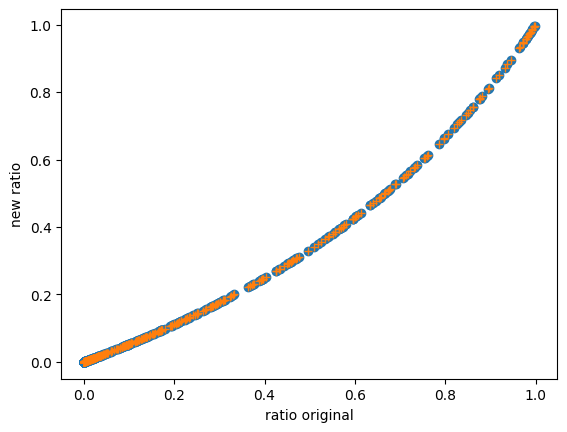

In [49]:
# plt.plot(inner_ratio_1.reshape(-1,1), inner_ratio_11.reshape(-1,1), '.');
plt.plot(inner_ratio_2.reshape(-1,1), inner_ratio_22.reshape(-1,1), 'o');
plt.plot(inner_ratio_2.reshape(-1,1), inner_ratio_22.reshape(-1,1), '+');
# plt.plot(inner_ratio_3.reshape(-1,1), inner_ratio_33.reshape(-1,1), '.');
plt.xlabel('ratio original')
plt.ylabel('new ratio')

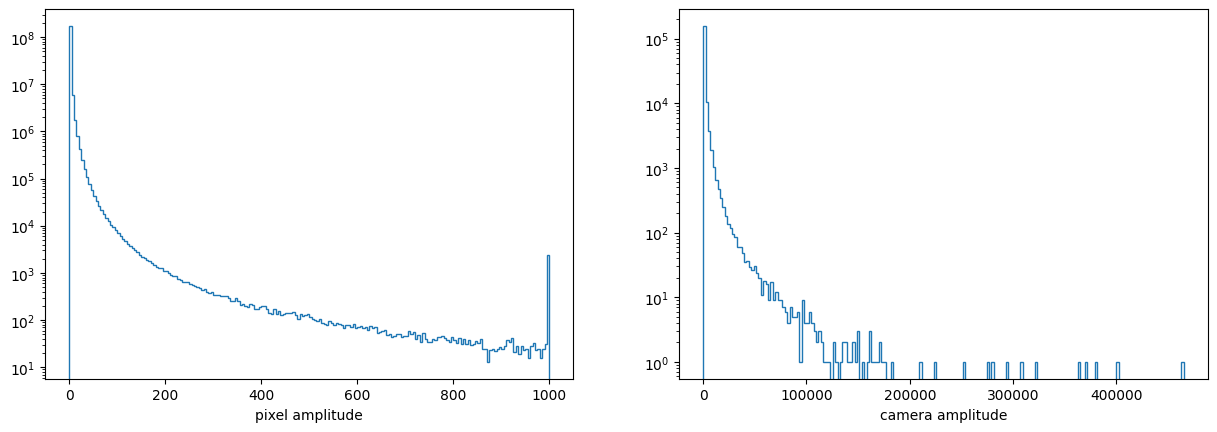

In [50]:
fig, ax = plt.subplots(1,2)
ax[0].hist(data_in.reshape(-1,1), 200, histtype='step',)
ax[0].set_yscale('log')
ax[0].set_xlabel('pixel amplitude')

ax[1].hist(np.sum(data_in, axis=1), 200, histtype='step',)
ax[1].set_yscale('log')
ax[1].set_xlabel('camera amplitude')

fig.set_figwidth(15)

## Data labelling

labelled-dazzlecameras : 915
labelled-non dazzlecameras : 177085
dazzlecameras abundance : 0.5167010192845244 %


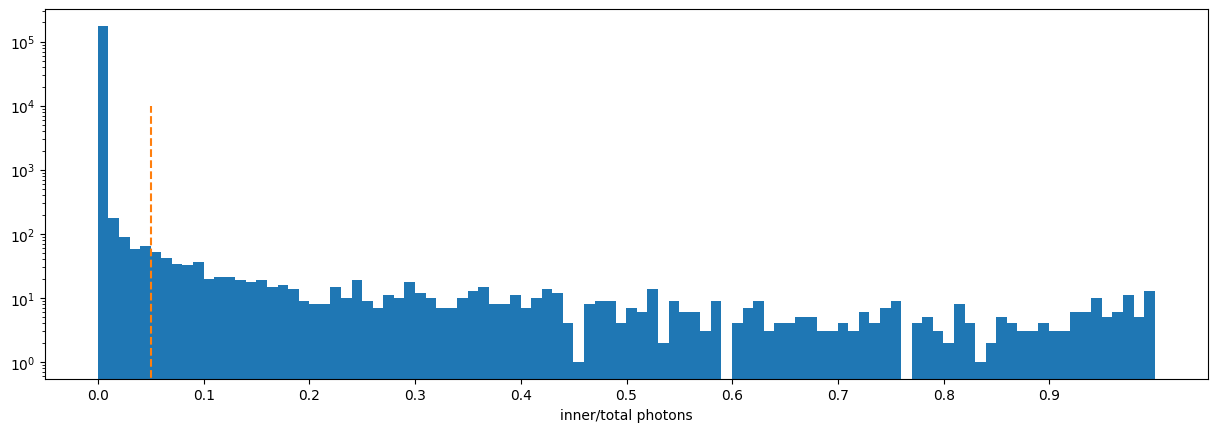

In [90]:
###### parameters #################
ph_threshold = 50                 #
ratio_threshold = 0.05            #
###################################

label = np.zeros(inner_ph_in.shape[0])

for i in np.where( (inner_ratio > ratio_threshold) & (inner_ph_in > ph_threshold) )[0]:
    label[i] = 1
    
n_dazzled = label[label==1].shape[0]
n_not_dazzled = label[label==0].shape[0]
print('labelled-dazzlecameras :', n_dazzled )
print('labelled-non dazzlecameras :', n_not_dazzled )
print('dazzlecameras abundance :', 100*n_dazzled/n_not_dazzled, '%')

fig = plt.figure()
plt.hist(inner_ratio, 100)
plt.yscale('log')
plt.xticks(np.arange(0, 1, 0.1))
plt.plot([ratio_threshold, ratio_threshold],[0,1e4], '--')
plt.xlabel('inner/total photons')
fig.set_figwidth(15)

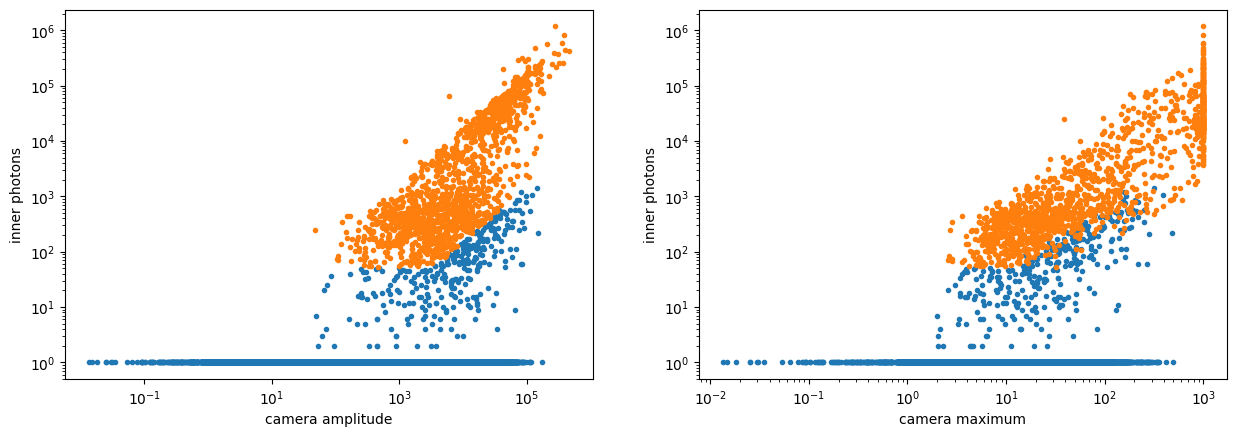

In [52]:
data_ = np.concatenate((data_in_1.reshape(-1, cam_side_length**2), data_in_2.reshape(-1, cam_side_length**2)))
fig, ax = plt.subplots(1,2)
ax[0].plot(np.sum(data_in, axis=1)[np.where(label==0)[0]], 1 + inner_ph_in[np.where(label==0)[0]], '.')
ax[0].plot(np.sum(data_in, axis=1)[np.where(label==1)[0]], inner_ph_in[np.where(label==1)[0]], '.')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('camera amplitude')
ax[0].set_ylabel('inner photons')
# plt.xlim(right=200000)
# plt.ylim(top=0.25e6)
ax[1].plot(np.max(data_in, axis=1)[np.where(label==0)[0]], 1 + inner_ph_in[np.where(label==0)[0]], '.')
ax[1].plot(np.max(data_in, axis=1)[np.where(label==1)[0]], inner_ph_in[np.where(label==1)[0]], '.')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('camera maximum')
ax[1].set_ylabel('inner photons')

fig.set_figwidth(15)

In [53]:
# data_ = np.concatenate((data_in_1.reshape(-1, cam_side_length**2), data_in_2.reshape(-1, cam_side_length**2), data_in_3.reshape(-1, cam_side_length**2)))
# data_[data_>1000] = 1000
# in_ph = np.concatenate((np.ravel(inner_ph_in_1, order='F'), np.ravel(inner_ph_in_2, order='F'), np.ravel(inner_ph_in_3, order='F')))
# in_ratio = np.concatenate((np.ravel(inner_ratio_1, order='F'), np.ravel(inner_ratio_2, order='F'), np.ravel(inner_ratio_3, order='F')))
# in_ratio[np.isnan(in_ratio)] = 0
# lab = np.zeros(in_ph.shape[0])
# for i in np.where( (in_ratio > ratio_threshold) & (in_ph > ph_threshold) )[0]:
#     lab[i] = 1
# fig, ax = plt.subplots(1,2)
# ax[0].plot(np.sum(data_, axis=1)[np.where(lab==0)[0]], 1 + in_ph[np.where(lab==0)[0]], '.')
# ax[0].plot(np.sum(data_, axis=1)[np.where(lab==1)[0]], in_ph[np.where(lab==1)[0]], '.')
# ax[0].set_xscale('log')
# ax[0].set_yscale('log')
# ax[0].set_xlabel('camera amplitude')
# ax[0].set_ylabel('inner photons')
# # plt.xlim(right=200000)
# # plt.ylim(top=0.25e6)
# ax[1].plot(np.max(data_, axis=1)[np.where(lab==0)[0]], 1 + in_ph[np.where(lab==0)[0]], '.')
# ax[1].plot(np.max(data_, axis=1)[np.where(lab==1)[0]], in_ph[np.where(lab==1)[0]], '.')
# ax[1].set_xscale('log')
# ax[1].set_yscale('log')
# ax[1].set_xlabel('camera maximum')
# ax[1].set_ylabel('inner photons')

# fig.set_figwidth(15)

## Feature Extraction

C:\Users\Pc\AppData\Local\Temp\ipykernel_20440\911583007.py:5: RuntimeWarning: invalid value encountered in divide
  data_ratio = 1 - data_mean/data_max


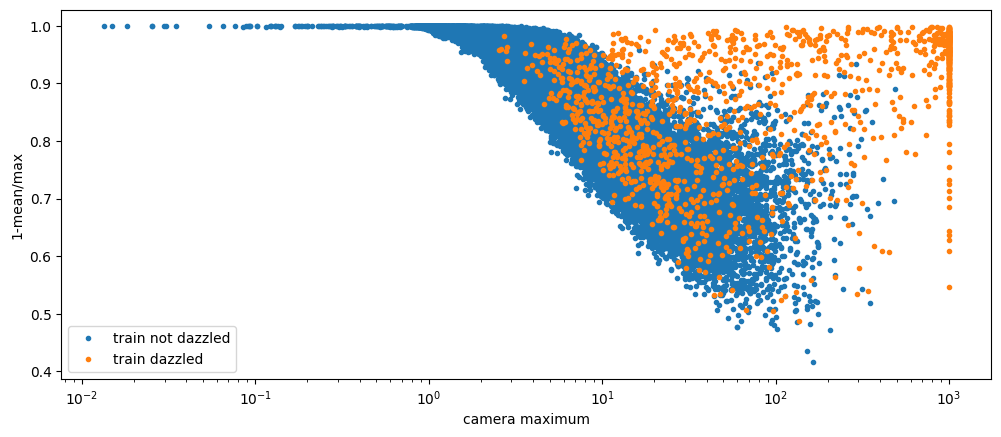

In [54]:
data_amp = np.sum(data_in.reshape(-1, cam_side_length**2), axis=1)
data_max = np.max(data_in.reshape(-1, cam_side_length**2), axis=1)
data_mean = np.mean(data_in.reshape(-1, cam_side_length**2), axis=1)

data_ratio = 1 - data_mean/data_max

# plt.plot(lab_not_bl_max, 1-ratio_not_bl_lab, '.', label='lab not blind')
#ax[0].plot(lab_bl_max, 1-ratio_bl_lab, 'o', label='lab blind')
plt.figure().set_figwidth(12)
plt.plot(data_max[label == 0], data_ratio[label == 0], '.', label='train not dazzled')
plt.plot(data_max[label == 1], data_ratio[label == 1], '.', label='train dazzled')
#plt.plot(data_max[np.where])

# ax[0].yscale('log')
plt.xscale('log')
plt.xlabel('camera maximum')
plt.ylabel('1-mean/max')
plt.legend()

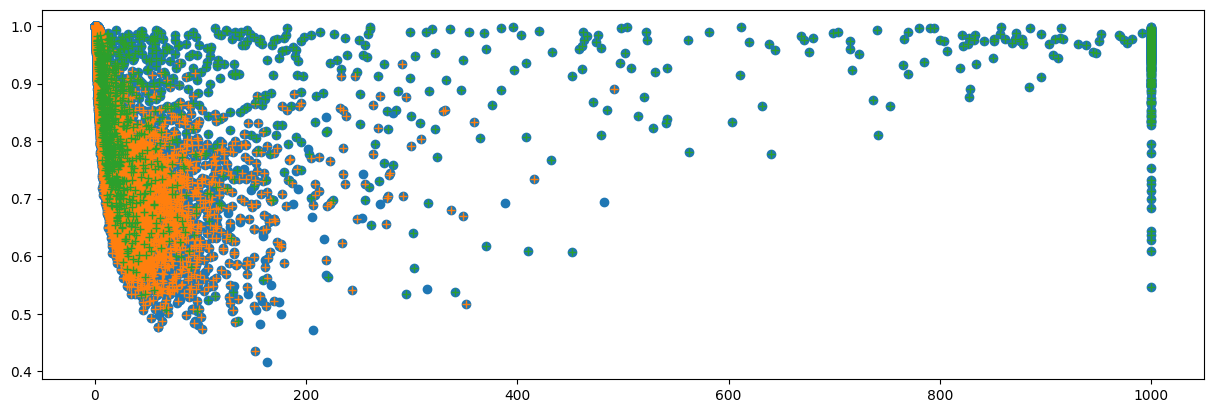

In [55]:
plt.figure().set_figwidth(15)
plt.plot(data_max, data_ratio, 'o')
plt.plot(data_max[np.where(inner_ratio==0)], data_ratio[np.where(inner_ratio==0)], '+')
plt.plot(data_max[np.where(inner_ratio>0.005)], data_ratio[np.where(inner_ratio>0.005)], '+')

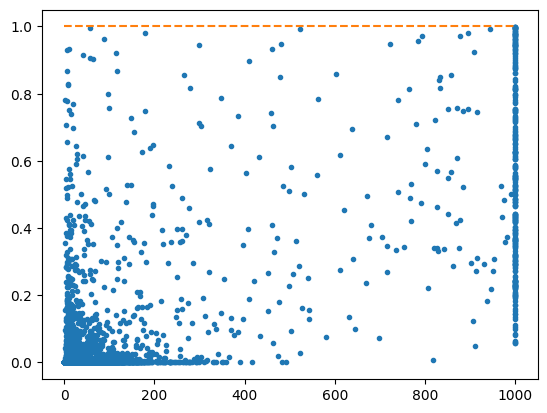

In [89]:
plt.plot(data_max, inner_ratio.reshape(-1,1),'.')
plt.plot([0,1000],[1,1], '--')
# plt.xlabel()
# plt.xlabel()

## Preprocessing

### Data Normalization

In [57]:
#### Apply RobustScaler
# scaler_ = RobustScaler().fit(data_in)
# scaler_data = scaler_.transform(data_in)#.reshape(-1, n_cam_in_grain, cam_side_length**2)
# #scaler_data = RobustScaler().fit_transform(data_in)

In [58]:
normalize_ = np.max(data_in, axis = 1) #np.max(data.reshape(-1, cam_side_length**2), axis = 1)
normalize_[np.where(normalize_ == 0)[0]] = 1e-5
#normalize_data = (scaler_data / (normalize_.reshape(-1,1)*np.ones((1, cam_side_length**2)))).reshape(-1, cam_side_length**2)#.reshape(-1, n_cam_in_grain, cam_side_length**2) #data
normalized_data = (data_in / (normalize_.reshape(-1,1)*np.ones((1, cam_side_length**2)))).reshape(-1, cam_side_length**2)#.reshape(-1, n_cam_in_grain, cam_side_length**2) #data
normalized_data.shape

(178000, 1024)

In [59]:
# e = 2000

# fig, ax = plt.subplots(1,2)
# d = ax[0].imshow(data_in[e].reshape(32,32))
# n = ax[1].imshow(normalize_data[e].reshape(32,32))
# plt.colorbar(d)
# plt.colorbar(n)
# fig.set_figwidth(15)

In [60]:
# REASON WHY WE ADOPTED THE TECHNIQUE OF RESHAPING INNER PH ARRAY AND THE RAVEL IT WITH "order='F'"

#cam = 7
#evn = 6
#pix = 8
#ip = [ c1(e1,e2,e3,...), c2(e1,e2,e3,...), c3(), c(4), ... ]
#d.reshape = [ e1(c1 - pix)
#              e1(c2 - pix)
#              e1(c3 - pix)
#              e1( ....) 
#              ...
#              e2(c1 - pix)
#              e2(c2 - pix)
#              e2(...)
#              ...
#              e3(...)
# ]

#### UNCOMMENT ONLY THE FOLLOWING LINES #####################################à

# ip = np.array([1,1,1,1,1,1,2,2,2,2,2,2,3,3,3,3,3,3,4,4,4,4,4,4,5,5,5,5,5,5,6,6,6,6,6,6,7,7,7,7,7,7])
# d = np.array([1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,
#               1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,
#               1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,
#               1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,
#               1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,
#               1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7])
# print(d.reshape(-1,8).shape)
# print(ip.shape)

# ip = ip.reshape(7,6)
# #print(d.reshape(-1,8))
# print(np.ravel(ip, order='F'))

In [61]:
# EXPLAINATION OF HOW TO PROPERLY PAD 31X31 ARRAY 

# ip = np.array([1,1,1,1,1,1,2,2,2,2,2,2,3,3,3,3,3,3,4,4,4,4,4,4,5,5,5,5,5,5,6,6,6,6,6,6,7,7,7,7,7,7])
# d0 = np.array([1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,
#               1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,
#               1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,
#               1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,
#               1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,
#               1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7])

# d = d0.reshape(-1,8,7)
# dr = np.array(resize_with_crop_or_pad(d.T.reshape(7,8,-1), 8, 9))
# print(d.shape)
# print(dr.T.shape)

### Split into test and training sets

In [62]:
sep = int(data_in.shape[0] * 0.8)

train_data, test_data = normalized_data[:sep], normalized_data[sep:] #normalize_data[:800], normalize_data[800:]
train_label, test_label = label[:sep], label[sep:]

print(train_data.shape)
print(train_label.shape)

(142400, 1024)
(142400,)


### Data augmentation for dazzled dataset

In [63]:
# data_augmentation = Sequential([
#   RandomFlip("horizontal_and_vertical"),
#   RandomRotation(0.2),
# ])

# # Add the image to a batch.
# image = cast(expand_dims(train_data[200], 0), float32)

# plt.figure(figsize=(10, 10))
# for i in range(9):
#   augmented_image = data_augmentation(image)
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(augmented_image[0])
#   plt.axis("off")

In [64]:
train_dazzled = train_data[np.where(train_label==1)]
train_not_dazzled = train_data[np.where(train_label==0)]

rdm = np.random.default_rng(12345)
rdm_x = rdm.integers(low=0, high=31, size=int(0.3*n_not_dazzled))
rdm_y = rdm.integers(low=0, high=31, size=int(0.3*n_not_dazzled))
artificial_train_dazzled = np.repeat(train_dazzled, int(0.3*n_not_dazzled/train_dazzled.shape[0]), axis=0).reshape(-1, cam_side_length, cam_side_length, 1)
for r in range(artificial_train_dazzled.shape[0]) :
    artificial_train_dazzled[r] = np.roll(artificial_train_dazzled[r], (rdm_x[r] ,rdm_y[r]), axis=(2,1))
    
artificial_train_label = np.ones(artificial_train_dazzled.shape[0])

train_data = train_data.reshape(-1, cam_side_length, cam_side_length, 1)
test_data = test_data.reshape(-1, cam_side_length, cam_side_length, 1)

# train_data /= renormalisation
# test_data /= renormalisation

# train_label = train_label.flatten()
# test_label = test_label.flatten()

train_data_aug = np.append(artificial_train_dazzled, train_data, axis=0).astype('float32')
train_label_aug = np.append(artificial_train_label, train_label).astype('float32')

# train_data = train_data.astype('float32')
# test_data = test_data.astype('float32')

# data_to_shuffle = np.column_stack((train_data.reshape(-1, cam_side_length**2), train_label))
# print(data_to_shuffle.shape)
# print(train_label.shape)
# print(train_data.reshape(-1, cam_side_length**2).shape)
#train_data = random.shuffle(train_data, 25)

train_label_ohe = to_categorical(train_label_aug,2)
test_label_ohe = to_categorical(test_label,2)

#train_label_ohe.shape

## CNN model


In [65]:
# lr_schedule = schedules.ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=10000,
#     decay_rate=0.9)
# #optimizer = Nadam(learning_rate=lr_schedule)

In [66]:
#create model
model = Sequential()
#add model layers
model.add(Input(shape=(cam_side_length, cam_side_length, 1)))
#model.add(data_augmentation)
model.add(Conv2D(32, kernel_size=3, activation='relu')) #input_shape=(cam_side_length, cam_side_length, 1)
#model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
# model.add(Dropout(0.3))              
model.add(Conv2D(64, kernel_size=3, activation='relu'))
#model.add(Conv2D(64, kernel_size=3, activation='relu'))
# model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))    
model.add(Conv2D(128, kernel_size=3, activation='relu'))    #eliminate?
# model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))     #eliminate?
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
#model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid'))  #softmax

In [67]:
#compile model using accuracy to measure model performance
model.compile(optimizer=Nadam(learning_rate=0.001), loss=BinaryCrossentropy(from_logits=False), metrics=[F1Score(num_classes=2)]) #AUC() F1Score(num_classes=2)  #SparseCategoricalCrossentropy(from_logits=True) BinaryCrossentropy(from_logits=True)
                                                                                        #'binary_crossentropy''categorical_crossentropy'
                                                                                        #metrics=[metricBinaryCrossentropy(from_logits=True)] 'binary_accuracy'
                                                                                        # FalseNegatives(thresholds=0)
                                                                                        # BinaryIoU(target_class_ids=[0, 1], threshold=0.7)

#model.summary()

# Train the model
#with tf.device('/device:GPU:0'):
with tf.device('/CPU:0'):
    history_callback = model.fit(train_data_aug, train_label_ohe, batch_size=256, validation_split=0.25, epochs= 10) #validation_data=(test_data, test_label_ohe)  #_ohe
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
#pd.DataFrame(history_callback.history).plot(logy=True)

Epoch 1/10
571/571 [==============================] - 70s 116ms/step - loss: 0.2276 - f1_score: 0.8951 - val_loss: 0.1172 - val_f1_score: 0.6170
Epoch 2/10
571/571 [==============================] - 67s 117ms/step - loss: 0.1050 - f1_score: 0.9560 - val_loss: 0.2977 - val_f1_score: 0.5196
Epoch 3/10
571/571 [==============================] - 66s 116ms/step - loss: 0.0673 - f1_score: 0.9722 - val_loss: 0.0602 - val_f1_score: 0.7093
Epoch 4/10
571/571 [==============================] - 68s 120ms/step - loss: 0.0505 - f1_score: 0.9798 - val_loss: 0.0411 - val_f1_score: 0.7730
Epoch 5/10
571/571 [==============================] - 70s 123ms/step - loss: 0.0389 - f1_score: 0.9844 - val_loss: 0.0570 - val_f1_score: 0.7292
Epoch 6/10
571/571 [==============================] - 66s 116ms/step - loss: 0.0327 - f1_score: 0.9866 - val_loss: 0.0346 - val_f1_score: 0.7889
Epoch 7/10
571/571 [==============================] - 66s 116ms/step - loss: 0.0278 - f1_score: 0.9888 - val_loss: 0.0456 - val_f1

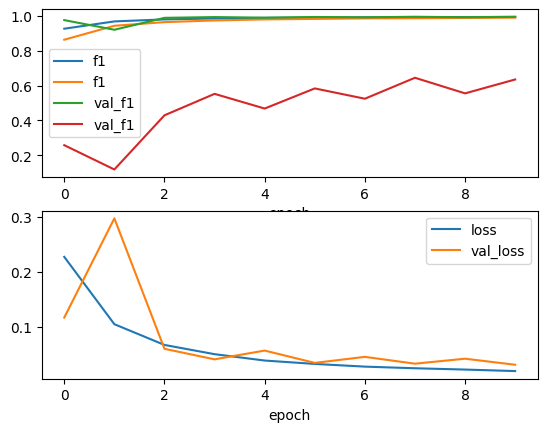

In [68]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history_callback.history['f1_score'], label='f1')
ax[0].plot(history_callback.history['val_f1_score'], label='val_f1')
ax[0].set_xlabel('epoch')
ax[0].legend()

ax[1].plot(history_callback.history['loss'], label='loss')
ax[1].plot(history_callback.history['val_loss'], label='val_loss')
ax[1].set_xlabel('epoch')
ax[1].legend()

### Performance check

1113/1113 [==============================] - 15s 13ms/step - loss: 0.0529 - f1_score: 0.7891
test_acc: [0.99243456 0.58574784]
1113/1113 [==============================] - 12s 11ms/step
labelled : 546
predicted : 729
true positive : 373
false positive : 356
false negative : 173


confusion matrix :
[[34698   356]
 [  173   373]]
precision : 0.5116598079561042
recall : 0.6831501831501832
f1 score : 0.5850980392156861
roc score : 0.8364972117325629


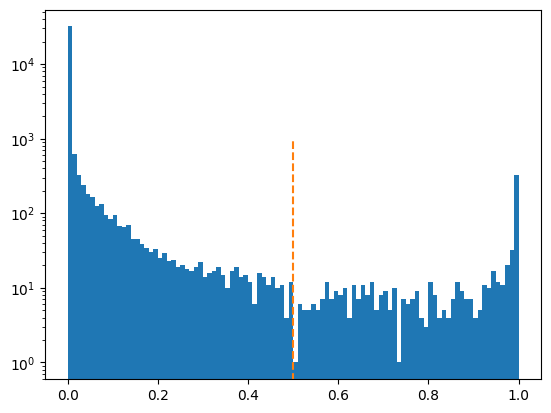

In [69]:
with tf.device('/CPU:0'):
    test_loss, test_acc = model.evaluate(test_data, test_label_ohe) #ohe?
    print('test_acc:', test_acc)

    pred0 = model.predict(test_data)
    pred00 = np.dot(pred0, np.array([0,1], dtype='float32'))

    plt.hist(pred00, 100)
    plt.plot([0.5, 0.5],[0,1e3], '--')
    plt.yscale('log')

    pred_lab = np.dot(test_label_ohe, np.array([0,1], dtype='float32'))
    pred_dec = np.dot(np.around(pred0), np.array([0,1], dtype='float32'))
    cm = confusion_matrix(pred_lab, pred_dec)
    prec = precision_score(pred_lab, pred_dec)
    reca = recall_score(pred_lab, pred_dec)
    f1 = f1_score(pred_lab, pred_dec)
    roc = roc_auc_score(pred_lab, pred_dec)

print('labelled :', np.where(pred_lab==1)[0].size)  
print('predicted :',  np.where(pred_dec==1)[0].size) 
print('true positive :', np.intersect1d(np.where(pred_lab==1), np.where(pred_dec==1)).shape[0])     
print('false positive :', np.intersect1d(np.where(pred_lab==0), np.where(pred_dec==1)).shape[0])     
print('false negative :', np.intersect1d(np.where(pred_lab==1), np.where(pred_dec==0)).shape[0]) 
print('\n')
print('confusion matrix :')
print(cm)
print('precision :', prec)
print('recall :', reca)
print('f1 score :', f1)
print('roc score :', roc)
#
#print(np.where(pred_dec==1))
#print(np.where(pred_lab==1))
non_scaled = data_in[sep:].reshape(-1, cam_side_length, cam_side_length, 1)
write_pdf = False
if write_pdf :
    n = 0
    pdf = PdfPages('./cnn_f1_3_3.pdf')
    for evn in np.intersect1d(np.where(pred_lab==1), np.where(pred_dec==1)):
        fig, ax = plt.subplots(1,2) #figure()
        fig.set_figwidth(15)
        matrix0 = ax[0].pcolormesh(test_data[evn].reshape(cam_side_length,cam_side_length)) #*renormalisation
        fig.colorbar(matrix0)
        ax[0].set_title('TRUE positive')
        ax[0].set_xlabel('inner ph: '+str(inner_ph_in[sep+evn])+' - ratio: '+str(inner_ratio[sep+evn]))
        matrix1 = ax[1].pcolormesh(non_scaled[evn].reshape(cam_side_length,cam_side_length)) #*renormalisation
        fig.colorbar(matrix1)
        ax[1].set_title('TRUE positive')
        pdf.savefig(fig)
        plt.close()
    for evn in np.intersect1d(np.where(pred_lab==0), np.where(pred_dec==1)):
        fig, ax = plt.subplots(1,2) #figure()
        fig.set_figwidth(15)
        matrix0 = ax[0].pcolormesh(test_data[evn].reshape(cam_side_length,cam_side_length)) #*renormalisation
        fig.colorbar(matrix0)
        ax[0].set_title('FALSE positive')
        ax[0].set_xlabel('inner ph: '+str(inner_ph_in[sep+evn])+' - ratio: '+str(inner_ratio[sep+evn]))
        matrix1 = ax[1].pcolormesh(non_scaled[evn].reshape(cam_side_length,cam_side_length)) #*renormalisation
        fig.colorbar(matrix1)
        pdf.savefig(fig)
        plt.close()
    for evn in np.intersect1d(np.where(pred_lab==1), np.where(pred_dec==0)):
        fig, ax = plt.subplots(1,2) #figure()
        fig.set_figwidth(15)
        matrix0 = ax[0].pcolormesh(test_data[evn].reshape(cam_side_length,cam_side_length)) #*renormalisation
        fig.colorbar(matrix0)
        ax[0].set_title('FALSE negative')
        ax[0].set_xlabel('inner ph: '+str(inner_ph_in[sep+evn])+' - ratio: '+str(inner_ratio[sep+evn]))
        matrix1 = ax[1].pcolormesh(non_scaled[evn].reshape(cam_side_length,cam_side_length)) #*renormalisation
        fig.colorbar(matrix1)
        pdf.savefig(fig)
        plt.close()
    # for evn in np.intersect1d(np.where(pred_lab==0), np.where(pred_dec==0)):
    #     n += 1
    #     while n < 50:
    #         fig, ax = plt.subplots(1,2) #figure()
    #         fig.set_figwidth(15)
    #         matrix0 = ax[0].pcolormesh(test_data[evn].reshape(cam_side_length,cam_side_length)) #*renormalisation
    #         fig.colorbar(matrix0)
    #         ax[0].set_title('TRUE negative')
    #         matrix1 = ax[1].pcolormesh(non_scaled[evn].reshape(cam_side_length,cam_side_length)) #*renormalisation
    #         fig.colorbar(matrix1)
    #         pdf.savefig(fig)
    #         plt.close()        
    pdf.close()

## Prediction vs MC truth visualization

C:\Users\Pc\AppData\Local\Temp\ipykernel_20440\1905197441.py:36: RuntimeWarning: invalid value encountered in divide
  ratio_not_bl_lab = lab_not_bl_mean/lab_not_bl_max
C:\Users\Pc\AppData\Local\Temp\ipykernel_20440\1905197441.py:38: RuntimeWarning: invalid value encountered in divide
  ratio_not_bl_pred = pred_not_bl_mean/pred_not_bl_max


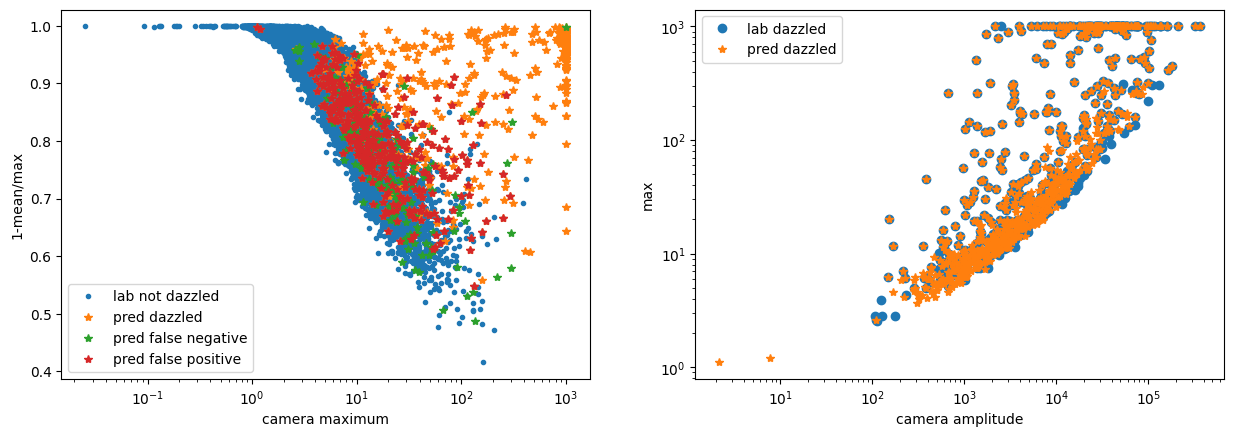

In [70]:
test_d = data_in[sep:]
#test_d = MaxAbsScaler().fit_transform(data_in[sep:])

lab_bl = test_d[np.where(pred_lab==1)]
lab_not_bl = test_d[np.where(pred_lab==0)]
pred_bl = test_d[np.where(pred_dec==1)]
pred_not_bl = test_d[np.where(pred_dec==0)]
pred_fn = test_d[np.intersect1d(np.where(pred_lab==1), np.where(pred_dec==0))]
pred_fp = test_d[np.intersect1d(np.where(pred_lab==0), np.where(pred_dec==1))]

lab_not_bl_amp = np.sum(lab_not_bl, axis=1)
lab_bl_amp = np.sum(lab_bl, axis=1)
pred_bl_amp = np.sum(pred_bl, axis=1)
pred_not_bl_amp = np.sum(pred_not_bl, axis=1)
pred_fn_amp = np.sum(pred_fn, axis=1)
pred_fp_amp = np.sum(pred_fp, axis=1)
# pred_bl_mod = stats.mode(pred_bl, axis=1)[0].ravel()
# lab_not_bl_mod = stats.mode(lab_not_bl, axis=1)[0].ravel()
# pred_fn_mod = stats.mode(pred_fn, axis=1)[0].ravel()

lab_not_bl_max = np.max(lab_not_bl, axis=1)
lab_bl_max = np.max(lab_bl, axis=1)
pred_bl_max = np.max(pred_bl, axis=1)
pred_not_bl_max = np.max(pred_not_bl, axis=1)
pred_fn_max = np.max(pred_fn, axis=1)
pred_fp_max = np.max(pred_fp, axis=1)

lab_not_bl_mean = np.mean(lab_not_bl, axis=1)
lab_bl_mean = np.mean(lab_bl, axis=1)
pred_bl_mean = np.mean(pred_bl, axis=1)
pred_not_bl_mean = np.mean(pred_not_bl, axis=1)
pred_fn_mean = np.mean(pred_fn, axis=1)
pred_fp_mean = np.mean(pred_fp, axis=1)

ratio_bl_lab = lab_bl_mean/lab_bl_max
ratio_not_bl_lab = lab_not_bl_mean/lab_not_bl_max
ratio_bl_pred = pred_bl_mean/pred_bl_max
ratio_not_bl_pred = pred_not_bl_mean/pred_not_bl_max
ratio_fn_pred = pred_fn_mean/pred_fn_max
ratio_fp_pred = pred_fp_mean/pred_fp_max

fig, ax = plt.subplots(1,2)
ax[0].plot(lab_not_bl_max, 1-ratio_not_bl_lab, '.', label='lab not dazzled')
#ax[0].plot(lab_bl_max, 1-ratio_bl_lab, 'o', label='lab blind')
ax[0].plot(pred_bl_max, 1-ratio_bl_pred, '*', label='pred dazzled')
ax[0].plot(pred_fn_max, 1-ratio_fn_pred, '*', label='pred false negative')
ax[0].plot(pred_fp_max, 1-ratio_fp_pred, '*', label='pred false positive')
# ax[0].yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlabel('camera maximum')
ax[0].set_ylabel('1-mean/max')
ax[0].legend()

ax[1].plot(lab_bl_amp, lab_bl_max, 'o', label='lab dazzled')
ax[1].plot(pred_bl_amp, pred_bl_max, '*', label='pred dazzled')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('camera amplitude')
ax[1].set_ylabel('max')
ax[1].legend()

# ax[1,0].plot(lab_not_bl_amp, 1-ratio_not_bl_lab, '.', label='lab not blind')
# #ax[0].plot(lab_bl_max, 1-ratio_bl_lab, 'o', label='lab blind')
# ax[1,0].plot(pred_bl_amp, 1-ratio_bl_pred, '*', label='pred blind')
# ax[1,0].plot(pred_fn_amp, 1-ratio_fn_pred, '*', label='pred false negative')
# # ax[0].yscale('log')
# ax[1,0].set_xscale('log')
# ax[1,0].set_xlabel('camera amplitude')
# ax[1,0].set_ylabel('1-mean/max')
# ax[1,0].legend()

# ax[1,1].plot(lab_not_bl_mod, lab_not_bl_max, '.', label='lab not blind')
# ax[1,1].plot(pred_bl_mod, pred_bl_max, '*', label='pred blind')
# ax[1,1].plot(pred_fn_mod, pred_fn_max, '*', label='pred false negative')

# ax[1,1].set_yscale('log')
# ax[1,1].set_xscale('log')
# ax[1,1].set_xlabel('camera mode')
# ax[1,1].set_ylabel('camera max')
# ax[1,1].legend()

fig.set_figwidth(15)
# fig.set_figheight(10)

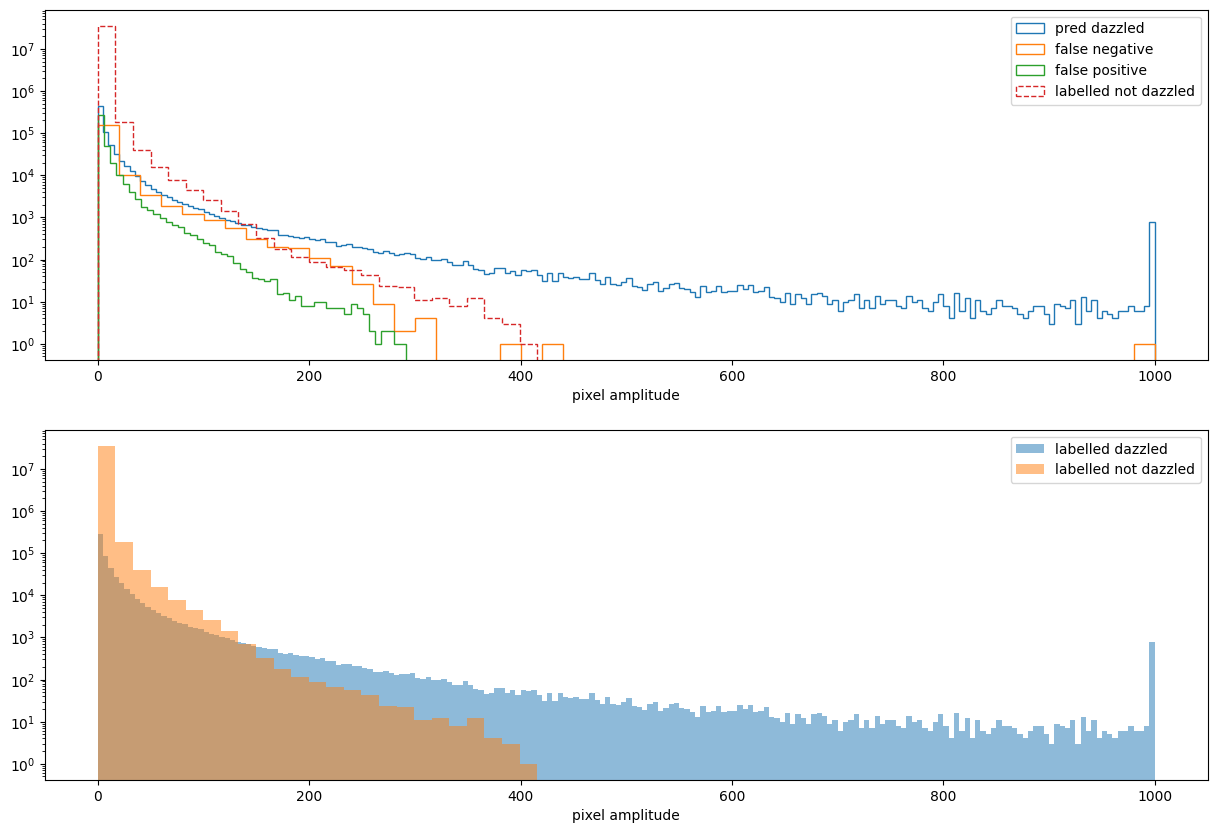

In [71]:
fig, ax = plt.subplots(2,1)

fig.set_figwidth(15)
fig.set_figheight(10)
ax[0].hist(pred_bl.reshape(-1,1), 200, histtype='step', label='pred dazzled');
ax[0].hist(pred_fn.reshape(-1,1), 50, histtype='step', label='false negative');
ax[0].hist(pred_fp.reshape(-1,1), 50, histtype='step', label='false positive');
ax[0].hist(lab_not_bl.reshape(-1,1), 25, histtype='step', ls='--', label='labelled not dazzled');
#plt.hist(np.concatenate((pred_bl.reshape(-1,1), pred_fn.reshape(-1,1))), 200, histtype='step', ls='dashed')
ax[0].set_yscale('log')
ax[0].set_xlabel('pixel amplitude')
ax[0].legend()


ax[1].hist(lab_bl.reshape(-1,1), 200, alpha=0.5, label='labelled dazzled');
ax[1].hist(lab_not_bl.reshape(-1,1), 25, alpha=0.5, label='labelled not dazzled');
ax[1].set_yscale('log')
ax[1].set_xlabel('pixel amplitude')
ax[1].legend()

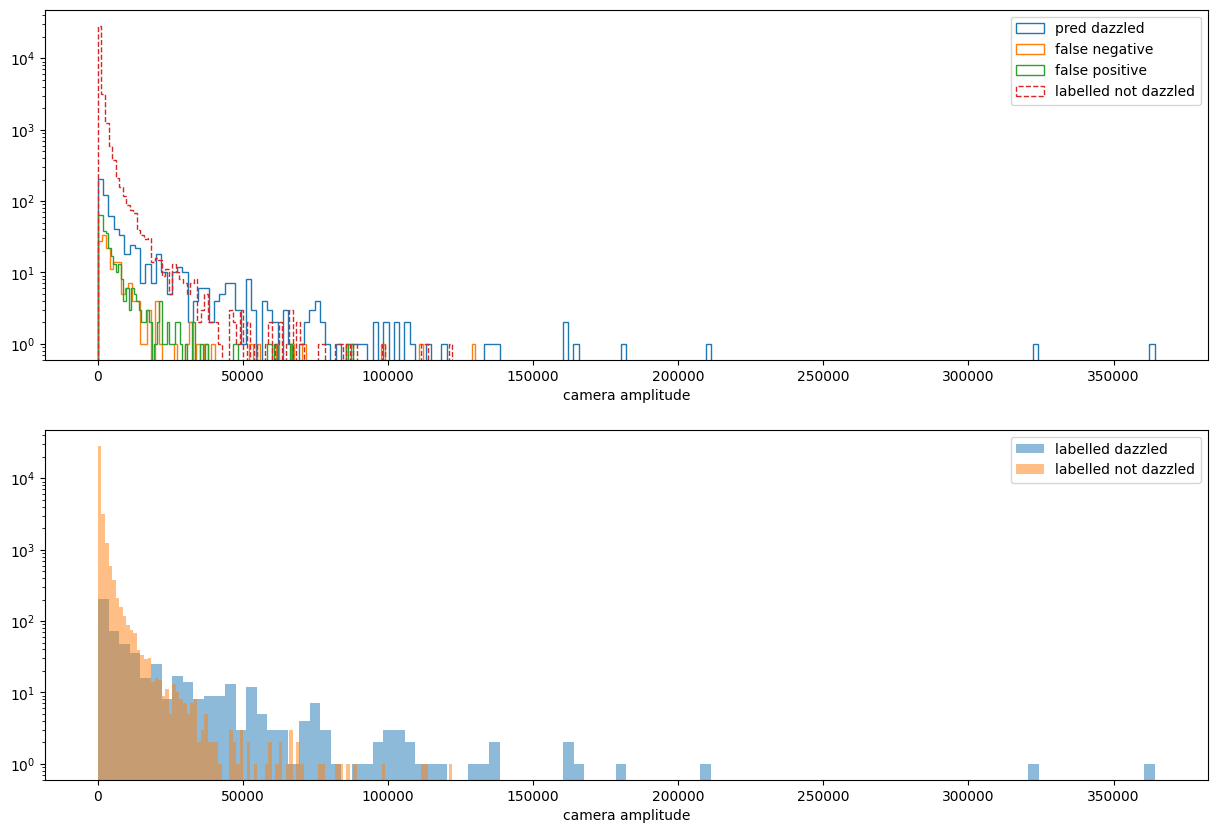

In [72]:
fig, ax = plt.subplots(2,1)
fig.set_figwidth(15)
fig.set_figheight(10)

ax[0].hist(pred_bl_amp.reshape(-1,1), 200, histtype='step', label='pred dazzled');
ax[0].hist(pred_fn_amp.reshape(-1,1), 100, histtype='step', label='false negative');
ax[0].hist(pred_fp_amp.reshape(-1,1), 100, histtype='step', label='false positive');
ax[0].hist(lab_not_bl_amp, 100, histtype='step', ls='--', label='labelled not dazzled');
#plt.hist(np.concatenate((pred_bl.reshape(-1,1), pred_fn.reshape(-1,1))), 200, histtype='step', ls='dashed')
ax[0].set_yscale('log')
ax[0].set_xlabel('camera amplitude')
ax[0].legend()

ax[1].hist(lab_bl_amp.reshape(-1,1), 100, alpha=0.5, label='labelled dazzled');
ax[1].hist(lab_not_bl_amp.reshape(-1,1), 100, alpha=0.5, label='labelled not dazzled');
ax[1].set_yscale('log')
ax[1].set_xlabel('camera amplitude')
ax[1].legend()

In [73]:
# img = 100
# plt.imshow(lab_bl[img].reshape(cam_side_length,cam_side_length))
# plt.colorbar()

In [74]:
## Train and Test sets visualization (blind only)

# train_d = data_in[:sep]
# #train_d = MaxAbsScaler().fit_transform(data_in[:sep])

# lab_bl_t = train_d[np.where(train_label==1)]
# lab_not_bl_t = train_d[np.where(train_label==0)]

# lab_not_bl_amp_t = np.sum(lab_not_bl_t, axis=1)
# lab_bl_amp_t = np.sum(lab_bl_t, axis=1)

# lab_not_bl_max_t = np.max(lab_not_bl_t, axis=1)
# lab_bl_max_t = np.max(lab_bl_t, axis=1)

# lab_not_bl_mean_t = np.mean(lab_not_bl_t, axis=1)
# lab_bl_mean_t = np.mean(lab_bl_t, axis=1)

# ratio_bl_lab_t = lab_bl_mean_t/lab_bl_max_t
# ratio_not_bl_lab_t = lab_not_bl_mean_t/lab_not_bl_max_t

# plt.plot(lab_not_bl_max, 1-ratio_not_bl_lab, '.', label='not blind')
# plt.plot(lab_bl_max_t, 1-ratio_bl_lab_t, '.', label='train blind')
# plt.plot(lab_bl_max, 1-ratio_bl_lab, '.', label='test blind')
# plt.xscale('log')
# plt.xlabel('camera maximum')
# plt.ylabel('1-mean/max')
# plt.legend()

In [75]:
save_model = False
if save_model:
    model_json = model.to_json()
    with open('model_highRoc.json', 'w') as json_file:
        json_file.write(model_json)
    model.save_weights('model_highRoc.h5')